## Introduction

In this notebook, i'll create a Image captioning model with the following project plan:
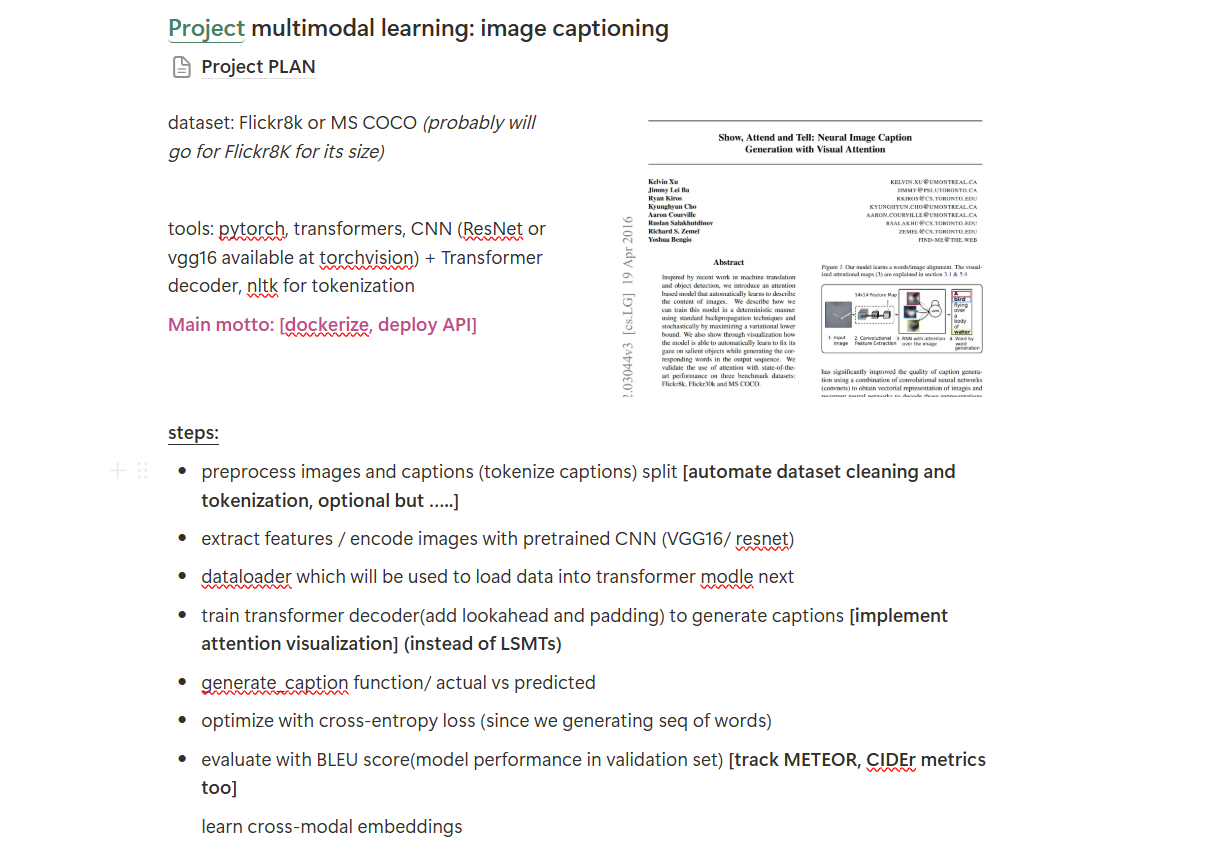

## Implementation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
from PIL import Image
from collections import Counter
import os

#### Examining data path with os

In [4]:
data_path = os.path.join(os.getcwd(), 'data')

In [5]:
data_path

'd:\\Github\\365DaysOfData\\10-Projects-Based-ML-DL\\03-Image-Captioning\\data'

In [6]:
os.path.exists(data_path)  # This will return True if the directory exists

True

In [7]:
data_items = os.listdir(data_path)
print(data_items)

['captions.txt', 'Images']


In [8]:
for item in data_items:
    item_path = os.path.join(data_path, item)

    if os.path.isfile(item_path):
        print(f"File: {item}")
        print(f"Size: {os.path.getsize(item_path)} bytes")
    elif os.path.isdir(item_path):
        print(f"Directory: {item}")
        print(f"Contains: {len(os.listdir(item_path))} items")

File: captions.txt
Size: 3319294 bytes
Directory: Images
Contains: 8091 items


#### Examining images with PIL

In [9]:
demo_img = Image.open(data_path + '/images/17273391_55cfc7d3d4.jpg')

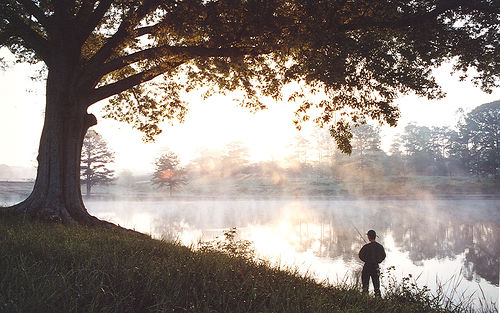

In [10]:
demo_img

#### Examining the whole data

In [11]:
data_path

'd:\\Github\\365DaysOfData\\10-Projects-Based-ML-DL\\03-Image-Captioning\\data'

In [12]:
df = pd.read_csv(data_path + '/captions.txt')

In [13]:
df.head()  # Display the first few rows of the DataFrame to check its structure

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [14]:
print(f"Number of unique images: {df['image'].nunique()}")
print(f"Number of unique captions: {df['caption'].nunique()}")

Number of unique images: 8091
Number of unique captions: 40201


#### Let's apply some data preprocessing and tokenize our data

In [15]:
import re
# 1. LITERAL CHARACTERS - exact match
# 2. DIGITS
# \d = any digit (0-9)
# \d+ = one or more digits
# 3. LETTERS AND WORDS
# \w = word character (letters, digits, underscore)
# \W = NON-word character (punctuation, spaces)
# 4. WHITESPACE
# \s = any whitespace (space, tab, newline)
# \s+ = one or more whitespace
def clean_caption(caption):
    caption = caption.lower()
    caption = caption.strip()
    # remove punctuations (except periods for sentence structure)
    caption = re.sub(r'[^\w\s.]', '', caption)
    # remove extra spaces
    caption = re.sub(r'\s+', ' ', caption)
    # remove numbers/digits
    caption = re.sub(r'\d+', '', caption)

    # add start and end tokens
    caption = '<start> ' + caption + ' <end>'
    return caption

test_caption = "A dog is running in the park! It's so happy... Really? Yes, 100% sure!!!"
cleaned_caption = clean_caption(test_caption)
print(f"Original: {test_caption}")
print(f"Cleaned:  {cleaned_caption}")


Original: A dog is running in the park! It's so happy... Really? Yes, 100% sure!!!
Cleaned:  <start> a dog is running in the park its so happy... really yes  sure <end>


In [16]:
df['cleaned_caption'] = df['caption'].apply(clean_caption)

df.head()  # Display the first few rows of the DataFrame to check the new column

,image,caption,cleaned_caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,<start> a child in a pink dress is climbing up...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,<start> a girl going into a wooden building . ...
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,<start> a little girl climbing into a wooden p...
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,<start> a little girl climbing the stairs to h...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,<start> a little girl in a pink dress going in...


In [17]:
for i in range(5):
    print(f"Original: {df['caption'].loc[i]}")
    print(f"Cleaned:  {df['cleaned_caption'].loc[i]}")
    print("-" * 50)

Original: A child in a pink dress is climbing up a set of stairs in an entry way .
Cleaned:  <start> a child in a pink dress is climbing up a set of stairs in an entry way . <end>
--------------------------------------------------
Original: A girl going into a wooden building .
Cleaned:  <start> a girl going into a wooden building . <end>
--------------------------------------------------
Original: A little girl climbing into a wooden playhouse .
Cleaned:  <start> a little girl climbing into a wooden playhouse . <end>
--------------------------------------------------
Original: A little girl climbing the stairs to her playhouse .
Cleaned:  <start> a little girl climbing the stairs to her playhouse . <end>
--------------------------------------------------
Original: A little girl in a pink dress going into a wooden cabin .
Cleaned:  <start> a little girl in a pink dress going into a wooden cabin . <end>
--------------------------------------------------


In [18]:
df.head(2)

,image,caption,cleaned_caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,<start> a child in a pink dress is climbing up...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,<start> a girl going into a wooden building . ...


In [19]:
' '.join(df['cleaned_caption'].values).split()

['<start>',
 'a',
 'child',
 'in',
 'a',
 'pink',
 'dress',
 'is',
 'climbing',
 'up',
 'a',
 'set',
 'of',
 'stairs',
 'in',
 'an',
 'entry',
 'way',
 '.',
 '<end>',
 '<start>',
 'a',
 'girl',
 'going',
 'into',
 'a',
 'wooden',
 'building',
 '.',
 '<end>',
 '<start>',
 'a',
 'little',
 'girl',
 'climbing',
 'into',
 'a',
 'wooden',
 'playhouse',
 '.',
 '<end>',
 '<start>',
 'a',
 'little',
 'girl',
 'climbing',
 'the',
 'stairs',
 'to',
 'her',
 'playhouse',
 '.',
 '<end>',
 '<start>',
 'a',
 'little',
 'girl',
 'in',
 'a',
 'pink',
 'dress',
 'going',
 'into',
 'a',
 'wooden',
 'cabin',
 '.',
 '<end>',
 '<start>',
 'a',
 'black',
 'dog',
 'and',
 'a',
 'spotted',
 'dog',
 'are',
 'fighting',
 '<end>',
 '<start>',
 'a',
 'black',
 'dog',
 'and',
 'a',
 'tricolored',
 'dog',
 'playing',
 'with',
 'each',
 'other',
 'on',
 'the',
 'road',
 '.',
 '<end>',
 '<start>',
 'a',
 'black',
 'dog',
 'and',
 'a',
 'white',
 'dog',
 'with',
 'brown',
 'spots',
 'are',
 'staring',
 'at',
 'each',


#### Now its time to build vocabulary using Counter

In [20]:
def build_vocabulary(captions, min_word_freq=2):
    # Count all words
    word_counts = Counter()
    
    for caption in captions:
        words = caption.split()
        word_counts.update(words)
    
    print(f"Total unique words found: {len(word_counts)}")
    print(f"Most common words: {word_counts.most_common(10)}")
    
    # Filter words by frequency but EXCLUDE special tokens from filtered list
    special_tokens = ['<pad>', '<unk>', '<start>', '<end>']
    vocab_words = [word for word, count in word_counts.items() 
                   if count >= min_word_freq and word not in special_tokens]
    
    # Add special tokens at the beginning
    vocab = special_tokens + vocab_words
    
    print(f"Vocabulary size (min_freq={min_word_freq}): {len(vocab)}")
    
    # Create mappings
    word2idx = {word: idx for idx, word in enumerate(vocab)}
    idx2word = {idx: word for word, idx in word2idx.items()}
    
    return vocab, word2idx, idx2word, word_counts

# Test the fixed version
vocab, word2idx, idx2word, word_counts = build_vocabulary(df['cleaned_caption'], min_word_freq=2)

print(f"\nFirst 20 words: {vocab[:20]}")
print(f"Special tokens: {vocab[:4]}")

# Check for duplicates
print(f"Any duplicates? {len(vocab) != len(set(vocab))}")
if len(vocab) != len(set(vocab)):
    from collections import Counter
    duplicates = [word for word, count in Counter(vocab).items() if count > 1]
    print(f"Duplicate words: {duplicates}")

Total unique words found: 8786
Most common words: [('a', 62986), ('<start>', 40455), ('<end>', 40455), ('.', 36577), ('in', 18974), ('the', 18418), ('on', 10743), ('is', 9345), ('and', 8851), ('dog', 8136)]
Vocabulary size (min_freq=2): 5203

First 20 words: ['<pad>', '<unk>', '<start>', '<end>', 'a', 'child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs', 'an', 'way', '.', 'girl', 'going']
Special tokens: ['<pad>', '<unk>', '<start>', '<end>']
Any duplicates? False


#### Finally, let's create a tokenization function:

In [21]:
df.head(2)

,image,caption,cleaned_caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,<start> a child in a pink dress is climbing up...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,<start> a girl going into a wooden building . ...


In [22]:
# Update tokenize_caption function to return both tokens and unknown count
def tokenize_caption(caption, word2idx, max_length=50):
    """
    Convert caption to sequence of token indices and count unknown words
    """
    words = caption.split()
    tokens = []
    unk_count = 0
    
    # Convert words to indices
    for word in words:
        if word in word2idx:
            tokens.append(word2idx[word])
        else:
            tokens.append(word2idx['<unk>'])
            unk_count += 1
    
    # Pad or truncate to max_length
    if len(tokens) < max_length:
        tokens.extend([word2idx['<pad>']] * (max_length - len(tokens)))
    else:
        tokens = tokens[:max_length]
    
    return tokens, unk_count

# Use the function
for caption in df['cleaned_caption']:
    tokens, unk_count = tokenize_caption(caption, word2idx, max_length=50)  # Longer for analysis

In [23]:
# Dataset analysis
print("\n=== DATASET ANALYSIS ===")

# Tokenize all captions
all_tokens = []
unknown_counts = []
caption_lengths = []

for caption in df['cleaned_caption']:
    tokens, unk_count = tokenize_caption(caption, word2idx, max_length=50)  # Longer for analysis
    
    # Find actual length (before padding)
    actual_length = 0
    for token in tokens:
        if token == word2idx['<pad>']:
            break
        actual_length += 1
    
    all_tokens.append(tokens)
    unknown_counts.append(unk_count)
    caption_lengths.append(actual_length)

# Statistics
import numpy as np

print(f"CAPTION LENGTH STATISTICS:")
print(f"- Average length: {np.mean(caption_lengths):.1f} words")
print(f"- Min length: {np.min(caption_lengths)} words")
print(f"- Max length: {np.max(caption_lengths)} words")
print(f"- 95th percentile: {np.percentile(caption_lengths, 95):.0f} words")

print(f"\n UNKNOWN WORDS:")
print(f"- Captions with unknown words: {sum(1 for x in unknown_counts if x > 0)}")
print(f"- Average unknown words per caption: {np.mean(unknown_counts):.2f}")




=== DATASET ANALYSIS ===
CAPTION LENGTH STATISTICS:
- Average length: 13.7 words
- Min length: 3 words
- Max length: 38 words
- 95th percentile: 21 words

 UNKNOWN WORDS:
- Captions with unknown words: 3275
- Average unknown words per caption: 0.09


#### Now we are going to split our data into train  and validation set

In [24]:
len(df)/df['image'].nunique()

5.0

In [25]:
unique_images = df['image'].unique()
print(f"Number of unique images: {len(unique_images)}")
n_train = int(len(unique_images) * 0.8)  # 80% for training
print(n_train)
train_images = unique_images[:n_train]
val_images = unique_images[n_train:]
print(train_images[:5])  # Display first 5 training images

train = df[df['image'].isin(train_images)]
valid = df[df['image'].isin(val_images)]

print(f"Train: {len(train)} samples from {len(train_images)} images")

Number of unique images: 8091
6472
['1000268201_693b08cb0e.jpg' '1001773457_577c3a7d70.jpg'
 '1002674143_1b742ab4b8.jpg' '1003163366_44323f5815.jpg'
 '1007129816_e794419615.jpg']
Train: 32360 samples from 6472 images


In [26]:
len(df['image'])  # Number of unique images

40455

In [27]:
len(unique_images)

8091

In [28]:
len(train), len(valid)

(32360, 8095)

In [29]:
import torchvision.models as models

resnet = models.resnet18(pretrained=True)
print(list(resnet.children())[-1:])  # Show last 3 modules

[Linear(in_features=512, out_features=1000, bias=True)]


d:\Github\365DaysOfData\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Github\365DaysOfData\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [30]:
list(resnet.children())[:-1] # ii shows all layers except the last one removes Linear(512, 1000) which outputs class probabilities

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [31]:
feature_extractor = nn.Sequential(*list(resnet.children())[:-1]) 

# input image size for ResNet-18 : 224x224 pixels with 3 channels (RGB) (1, 3, 224, 224)
# after conv1: (1, 64, 112, 112) # detects basic edges and textures
# after layer1 resnet blocks: (1, 64, 56, 56) because of stride=2 # combine edges into shapes
# after layer2: (1, 128, 28, 28) 
# after layer3: (1, 256, 14, 14) 
# after layer4: (1, 512, 7, 7)
# After adaptive pooling: (1, 512, 1, 1) so the feature extractor outputs a 512-dimensional vector for each image
# these 512 numbers contain the most important features of the image

feature_extractor.eval()  # Set to evaluation mode because we are not training it

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [32]:
data_path

'd:\\Github\\365DaysOfData\\10-Projects-Based-ML-DL\\03-Image-Captioning\\data'

Input image shape: torch.Size([1, 3, 224, 224])


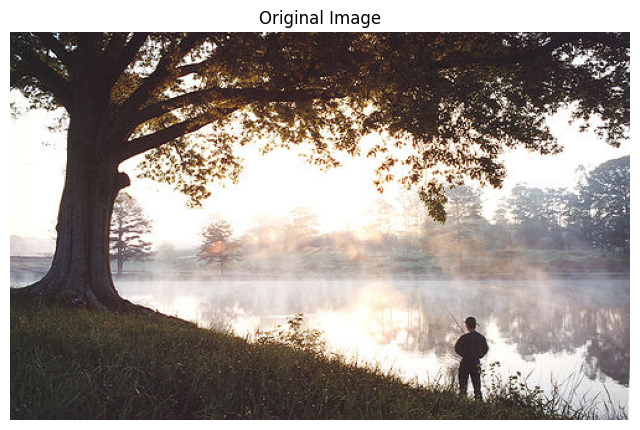

Starting with: torch.Size([1, 3, 224, 224])
After conv1+bn+relu: torch.Size([1, 64, 112, 112])


C:\Users\samir\AppData\Local\Temp\ipykernel_26004\2883263334.py:36: RuntimeWarning: invalid value encountered in divide
  feature_map = (feature_map - feature_map.min()) / (feature_map.max() - feature_map.min())


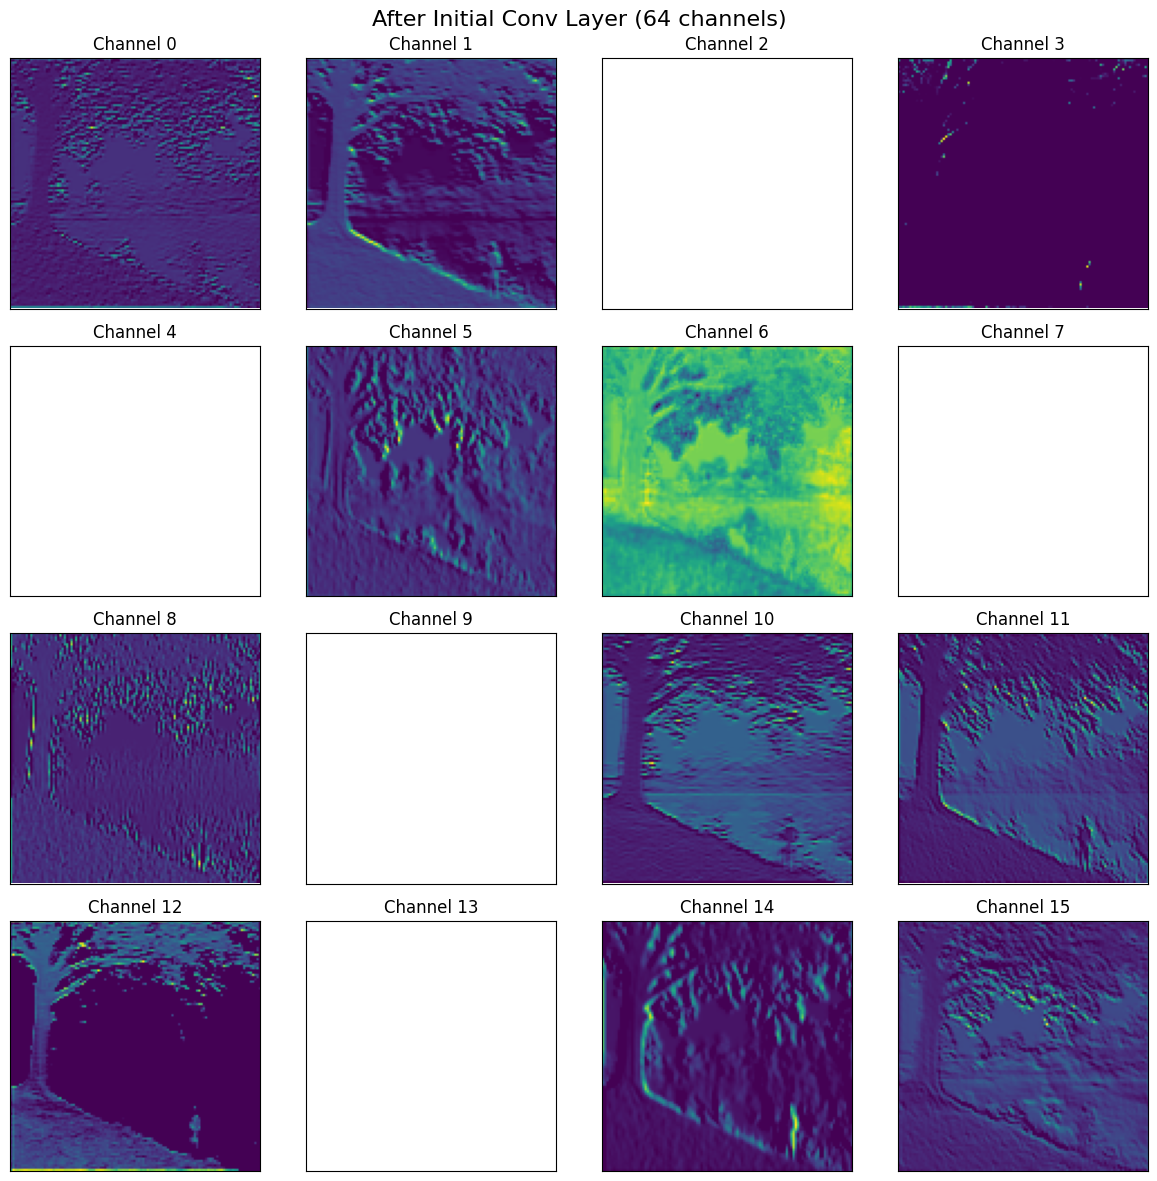

After maxpool: torch.Size([1, 64, 56, 56])
After layer1: torch.Size([1, 64, 56, 56])


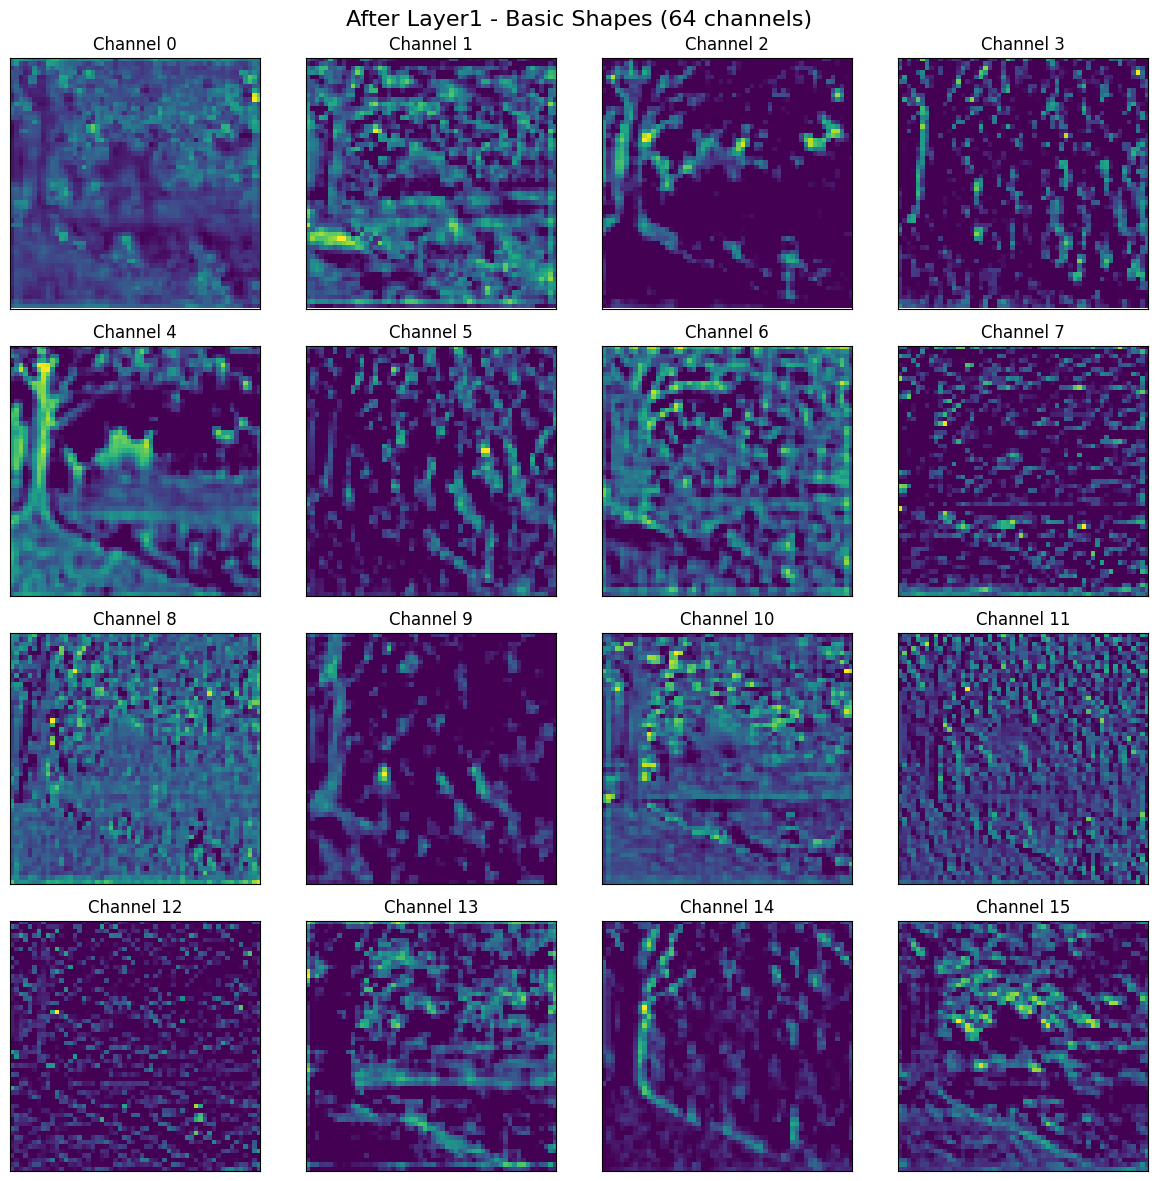

After layer2: torch.Size([1, 128, 28, 28])


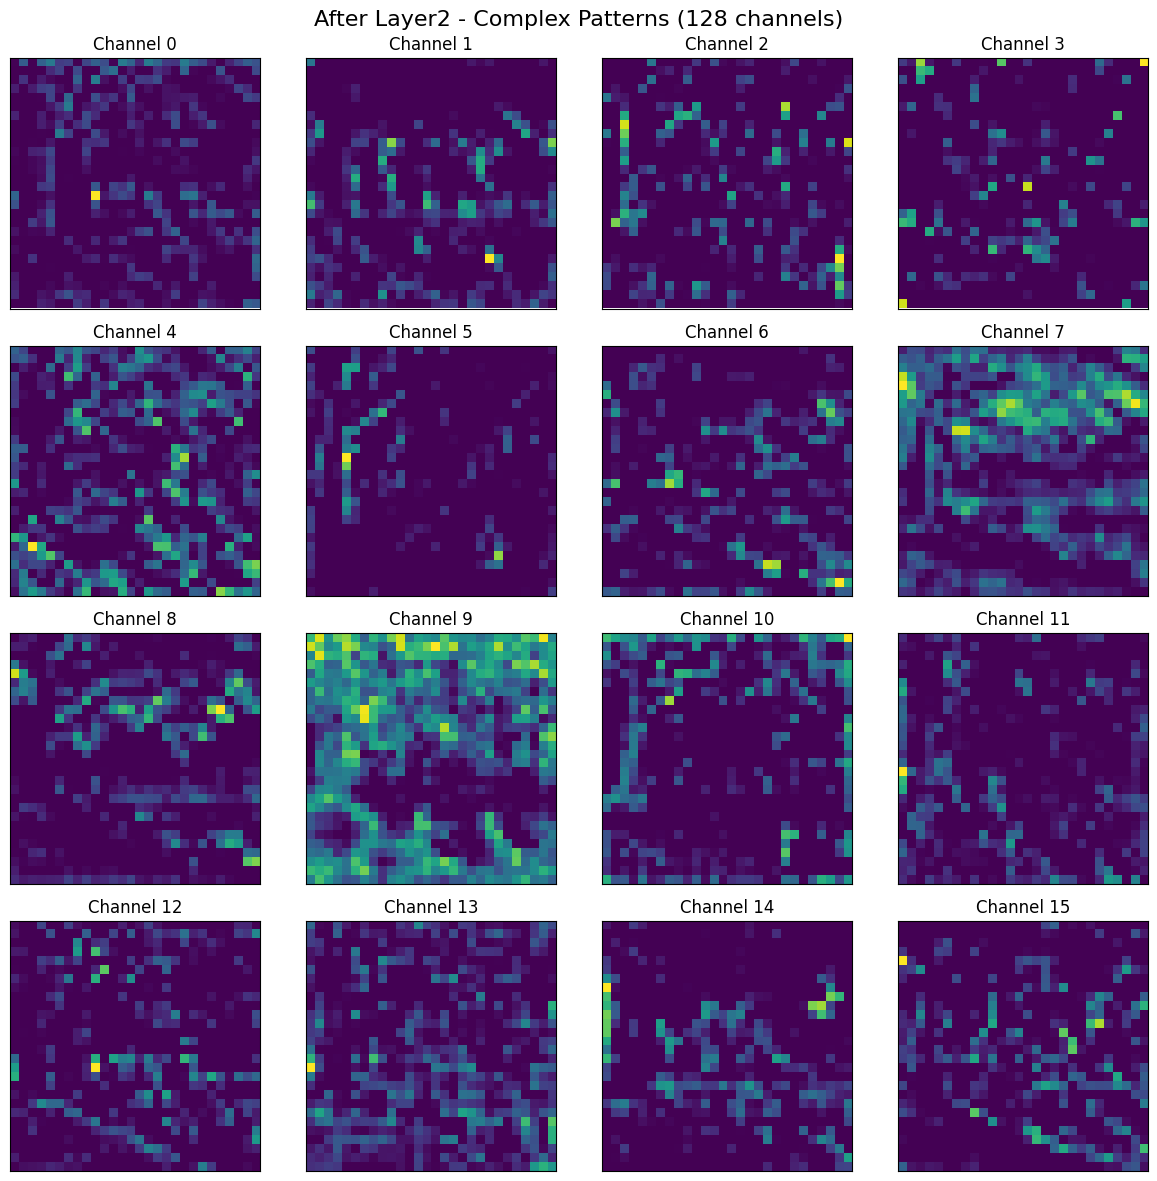

After layer3: torch.Size([1, 256, 14, 14])


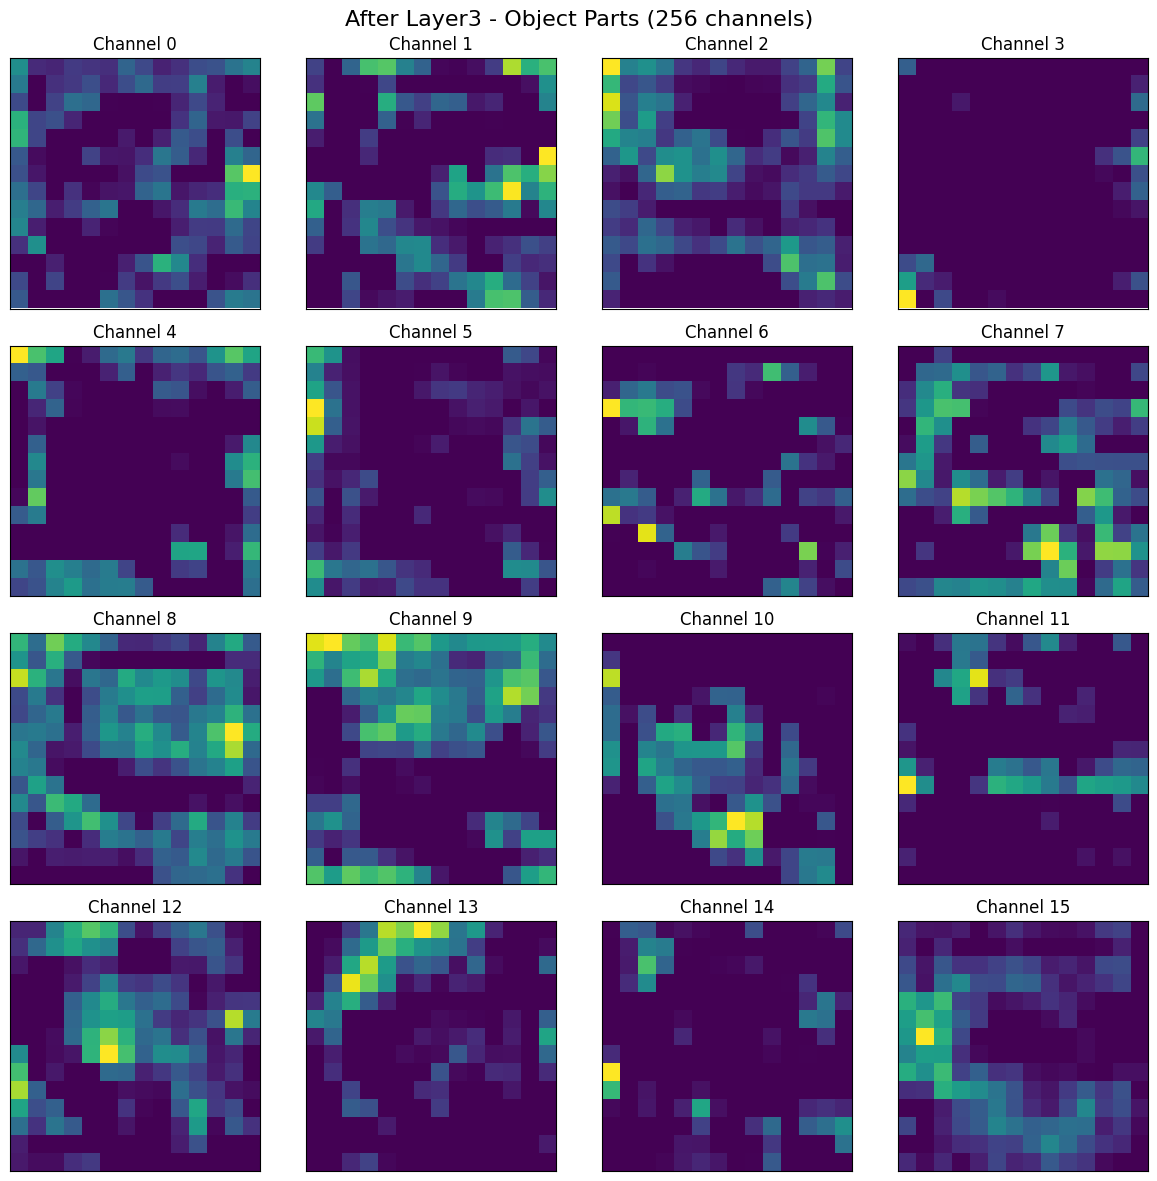

After layer4: torch.Size([1, 512, 7, 7])


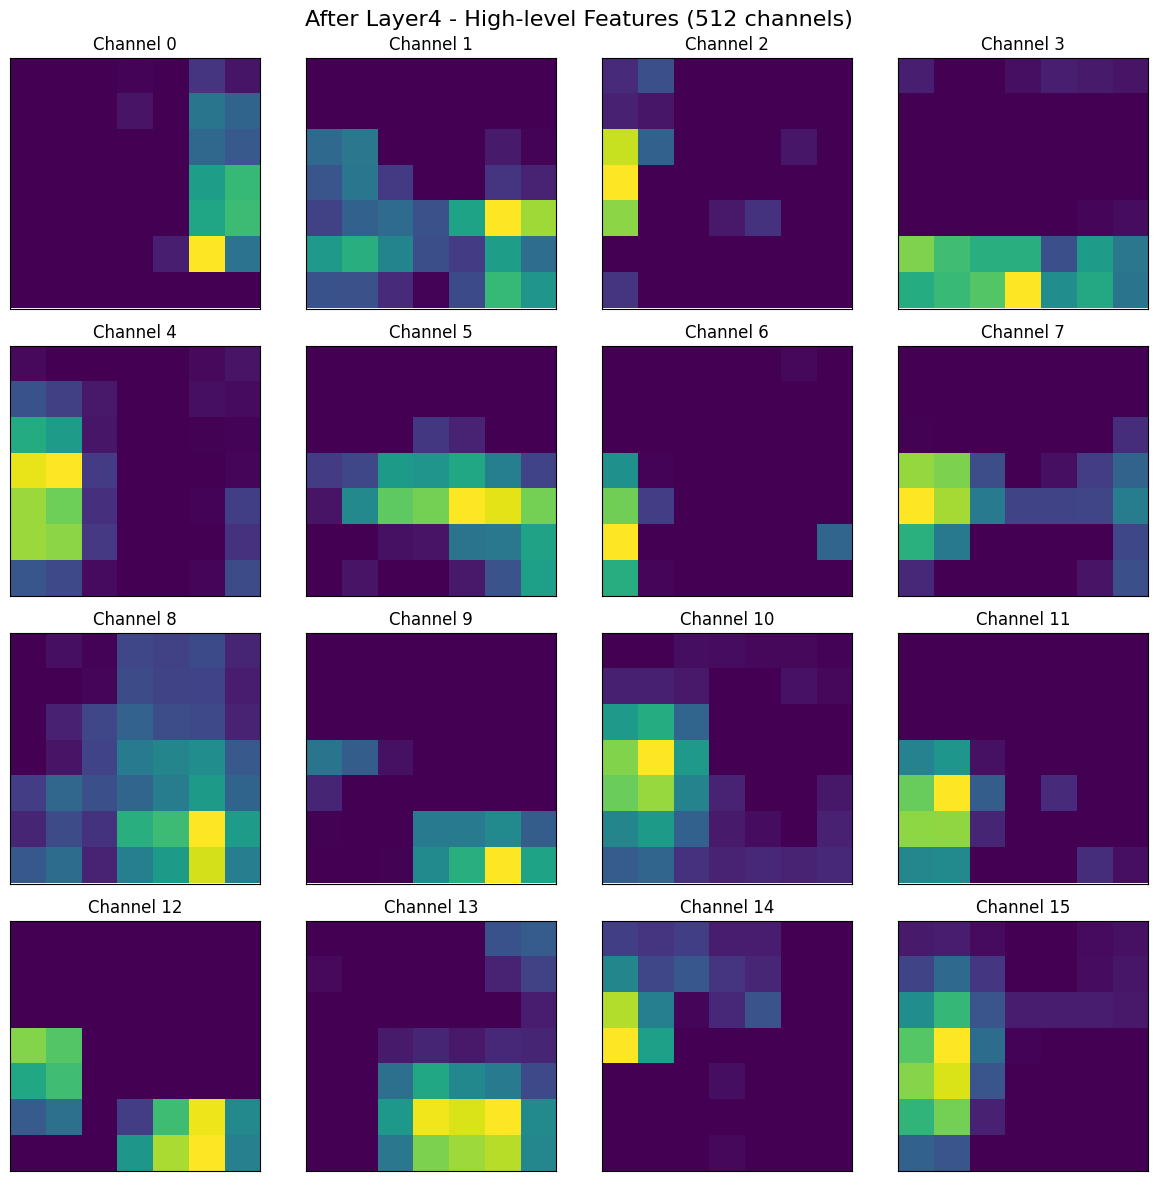

After global average pooling: torch.Size([1, 512, 1, 1])
Final feature vector shape: torch.Size([1, 512])


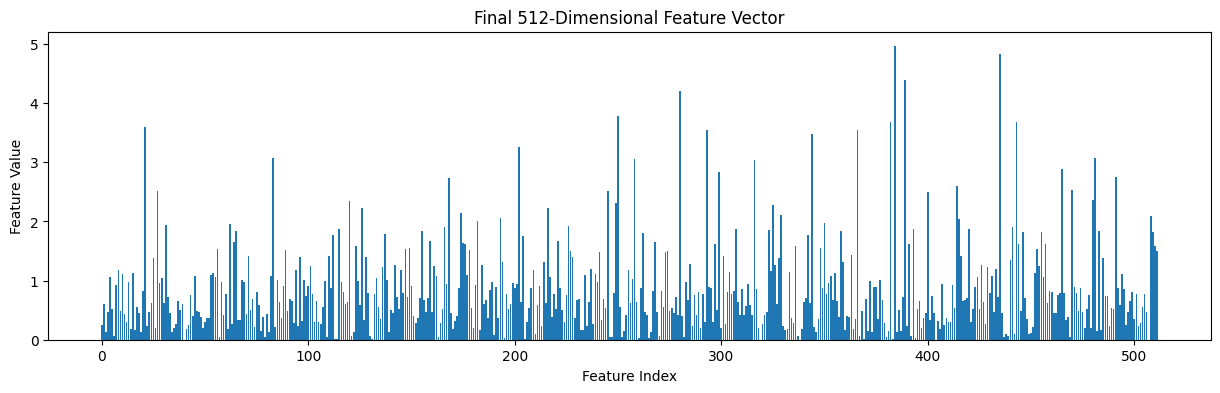

These 512 numbers represent the image content!
Sample feature values: [0.25170678 0.6032563  0.12693897 0.46749163 1.0606691  0.5138286
 0.06254047 0.92556024 1.177625   0.48671797]


In [33]:
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np

# Load and preprocess your demo image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the demo image
demo_img = Image.open(data_path + '/images/17273391_55cfc7d3d4.jpg')
input_tensor = transform(demo_img).unsqueeze(0)  # Add batch dimension

print(f"Input image shape: {input_tensor.shape}")

# Function to visualize feature maps
def visualize_feature_maps(feature_maps, title, max_channels=16):
    """Visualize first few channels of feature maps"""
    feature_maps = feature_maps.squeeze(0)  # Remove batch dimension
    num_channels = min(feature_maps.shape[0], max_channels)
    
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    fig.suptitle(title, fontsize=16)
    
    for i in range(16):
        row = i // 4
        col = i % 4
        
        if i < num_channels:
            # Normalize for visualization
            feature_map = feature_maps[i].detach().numpy()
            feature_map = (feature_map - feature_map.min()) / (feature_map.max() - feature_map.min())
            axes[row, col].imshow(feature_map, cmap='viridis')
            axes[row, col].set_title(f'Channel {i}')
        else:
            axes[row, col].axis('off')
        
        axes[row, col].set_xticks([])
        axes[row, col].set_yticks([])
    
    plt.tight_layout()
    plt.show()

# Show original image
plt.figure(figsize=(8, 6))
plt.imshow(demo_img)
plt.title("Original Image")
plt.axis('off')
plt.show()

# Extract individual layers from ResNet
resnet_layers = list(resnet.children())

# Process through each major stage
with torch.no_grad():
    x = input_tensor
    print(f"Starting with: {x.shape}")
    
    # Stage 1: Initial convolution + pooling
    x = resnet.conv1(x)
    x = resnet.bn1(x)
    x = resnet.relu(x)
    print(f"After conv1+bn+relu: {x.shape}")
    visualize_feature_maps(x, "After Initial Conv Layer (64 channels)", max_channels=16)
    
    x = resnet.maxpool(x)
    print(f"After maxpool: {x.shape}")
    
    # Stage 2: ResNet layer1 (64 channels)
    x = resnet.layer1(x)
    print(f"After layer1: {x.shape}")
    visualize_feature_maps(x, "After Layer1 - Basic Shapes (64 channels)", max_channels=16)
    
    # Stage 3: ResNet layer2 (128 channels)
    x = resnet.layer2(x)
    print(f"After layer2: {x.shape}")
    visualize_feature_maps(x, "After Layer2 - Complex Patterns (128 channels)", max_channels=16)
    
    # Stage 4: ResNet layer3 (256 channels)
    x = resnet.layer3(x)
    print(f"After layer3: {x.shape}")
    visualize_feature_maps(x, "After Layer3 - Object Parts (256 channels)", max_channels=16)
    
    # Stage 5: ResNet layer4 (512 channels)
    x = resnet.layer4(x)
    print(f"After layer4: {x.shape}")
    visualize_feature_maps(x, "After Layer4 - High-level Features (512 channels)", max_channels=16)
    
    # Stage 6: Global Average Pooling
    x = resnet.avgpool(x)
    print(f"After global average pooling: {x.shape}")
    
    # Show the final feature vector
    final_features = x.view(1, -1)
    print(f"Final feature vector shape: {final_features.shape}")
    
    # Visualize the final 512 features as a bar chart
    plt.figure(figsize=(15, 4))
    features_np = final_features.squeeze().numpy()
    plt.bar(range(len(features_np)), features_np)
    plt.title("Final 512-Dimensional Feature Vector")
    plt.xlabel("Feature Index")
    plt.ylabel("Feature Value")
    plt.show()
    
    print(f"These 512 numbers represent the image content!")
    print(f"Sample feature values: {features_np[:10]}")

In [34]:
# Test with your demo image
demo_img = Image.open(data_path + '/images/17273391_55cfc7d3d4.jpg')
print(f"Original image size: {demo_img.size}")

# Apply transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

img_tensor = transform(demo_img)
print(f"Transformed tensor shape: {img_tensor.shape}")

Original image size: (500, 313)
Transformed tensor shape: torch.Size([3, 224, 224])


In [35]:
# Extract features from the demo image
img_batch = img_tensor.unsqueeze(0)  # Add batch dimension: [1, 3, 224, 224]
print(f"Batch shape: {img_batch.shape}")

with torch.no_grad():
    features = feature_extractor(img_batch)
    features = features.view(features.size(0), -1)  # Flatten: [1, 512]

print(f"Extracted features shape: {features.shape}")
print(f"Feature sample: {features[0][:10]}")  # First 10 values

Batch shape: torch.Size([1, 3, 224, 224])
Extracted features shape: torch.Size([1, 512])
Feature sample: tensor([0.2517, 0.6033, 0.1269, 0.4675, 1.0607, 0.5138, 0.0625, 0.9256, 1.1776,
        0.4867])


In [36]:
unique_images

array(['1000268201_693b08cb0e.jpg', '1001773457_577c3a7d70.jpg',
       '1002674143_1b742ab4b8.jpg', ..., '99679241_adc853a5c0.jpg',
       '997338199_7343367d7f.jpg', '997722733_0cb5439472.jpg'],
      dtype=object)

In [37]:
print(len(train_images), len(val_images))

6472 1619


In [38]:
def extract_single_image_features(image_name, data_path, feature_extractor, transform):
    img_path = os.path.join(data_path, 'images', image_name)
    
    try:
        img = Image.open(img_path).convert('RGB')
        img_tensor = transform(img).unsqueeze(0)  # Add batch dim
        
        with torch.no_grad():
            features = feature_extractor(img_tensor)
            features = features.view(-1)  # Flatten to 1D: [512]
        
        return features
    except Exception as e:
        print(f"Error with {image_name}: {e}")
        return None

train_features = {}

for i, img_name in enumerate(train_images):
    features = extract_single_image_features(img_name, data_path, feature_extractor, transform)
    if features is not None:
        train_features[img_name] = features

    if i % 100 == 0:
        print(f"Processed {i}/{len(train_images)} images")

valid_features = {}
for i, img_name in enumerate(val_images):
    features = extract_single_image_features(img_name, data_path, feature_extractor, transform)
    if features is not None:
        valid_features[img_name] = features

    if i % 100 == 0:
        print(f"Processed {i}/{len(val_images)} images")

print(f"Extracted features for {len(train_features)} training images")
print(f"Extracted features for {len(valid_features)} validation images")

Processed 0/6472 images
Processed 100/6472 images
Processed 200/6472 images
Processed 300/6472 images
Processed 400/6472 images
Processed 500/6472 images
Processed 600/6472 images
Processed 700/6472 images
Processed 800/6472 images
Processed 900/6472 images
Processed 1000/6472 images
Processed 1100/6472 images
Processed 1200/6472 images
Processed 1300/6472 images
Processed 1400/6472 images
Processed 1500/6472 images
Processed 1600/6472 images
Processed 1700/6472 images
Processed 1800/6472 images
Processed 1900/6472 images
Processed 2000/6472 images
Processed 2100/6472 images
Processed 2200/6472 images
Processed 2300/6472 images
Processed 2400/6472 images
Processed 2500/6472 images
Processed 2600/6472 images
Processed 2700/6472 images
Processed 2800/6472 images
Processed 2900/6472 images
Processed 3000/6472 images
Processed 3100/6472 images
Processed 3200/6472 images
Processed 3300/6472 images
Processed 3400/6472 images
Processed 3500/6472 images
Processed 3600/6472 images
Processed 370

In [39]:
print(f"expected train features: {len(train_images)}, got {len(train_features)}")
print(f"expected valid features: {len(val_images)}, got {len(valid_features)}")

expected train features: 6472, got 6472
expected valid features: 1619, got 1619


In [40]:
img1_name = list(train_features.keys())[0]
img2_name = list(train_features.keys())[1]

feature1 = train_features[img1_name]
feature2 = train_features[img2_name]

# Calculate similarity (should be < 1.0 for different images)
similarity = torch.cosine_similarity(feature1, feature2, dim=0)
print(f"Cosine similarity between two random images: {similarity:.3f}")
print("(Should be < 1.0 - different images have different features)")

Cosine similarity between two random images: 0.490
(Should be < 1.0 - different images have different features)


In [41]:
# Save features so you don't have to re-extract
import pickle

with open('train_image_features.pkl', 'wb') as f:
    pickle.dump(train_features, f)
    
with open('valid_image_features.pkl', 'wb') as f:
    pickle.dump(valid_features, f)

print("✓ Features saved to disk!")
print("You can load them later with:")
print("with open('train_image_features.pkl', 'rb') as f:")
print("    train_features = pickle.load(f)")

✓ Features saved to disk!
You can load them later with:
with open('train_image_features.pkl', 'rb') as f:
    train_features = pickle.load(f)


In [42]:
sample_row = train.iloc[0]
print(f"Sample row:\n{sample_row}")
print(f"Image: {sample_row['image']}")
print(f"Caption: {sample_row['cleaned_caption']}")

Sample row:
image                                      1000268201_693b08cb0e.jpg
caption            A child in a pink dress is climbing up a set o...
cleaned_caption    <start> a child in a pink dress is climbing up...
Name: 0, dtype: object
Image: 1000268201_693b08cb0e.jpg
Caption: <start> a child in a pink dress is climbing up a set of stairs in an entry way . <end>


In [43]:
# tokenize the caption

tokens, _ = tokenize_caption(sample_row['cleaned_caption'], word2idx, max_length=50)
print(f"Tokens: {tokens}")
print(f"Tokenized caption: {[idx2word[idx] for idx in tokens if idx != word2idx['<pad>']]}")

Tokens: [2, 4, 5, 6, 4, 7, 8, 9, 10, 11, 4, 12, 13, 14, 6, 15, 1, 16, 17, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tokenized caption: ['<start>', 'a', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', '<unk>', 'way', '.', '<end>']


#### Understanding input vs target sequences for training


In [44]:
input_seq = tokens[:-1]    # Remove last token: [<start>, word1, word2, ..., <end>]
target_seq = tokens[1:]    # Remove first token: [word1, word2, ..., <end>, <pad>]
print(f"Input sequence: {input_seq}")
print(f"Target sequence: {target_seq}")

Input sequence: [2, 4, 5, 6, 4, 7, 8, 9, 10, 11, 4, 12, 13, 14, 6, 15, 1, 16, 17, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Target sequence: [4, 5, 6, 4, 7, 8, 9, 10, 11, 4, 12, 13, 14, 6, 15, 1, 16, 17, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [45]:

print(f"Input length: {len(input_seq)}")
print(f"Target length: {len(target_seq)}")
print(f"Input words: {[idx2word[t] for t in input_seq[:8]]}")
print(f"Target words: {[idx2word[t] for t in target_seq[:8]]}")

Input length: 49
Target length: 49
Input words: ['<start>', 'a', 'child', 'in', 'a', 'pink', 'dress', 'is']
Target words: ['a', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing']


In [46]:
img1_name

'1000268201_693b08cb0e.jpg'

In [47]:
print(train_features[img1_name].shape) 

torch.Size([512])


#### lets create Dataset class that combines pre-extracted image features with tokenized captions (but why create? cause our data comes from mutliple places, image features from model, text data in dataframe, wore2index vocab) custom dataset brings all these together into one clean interface

In [ ]:
# Lets understand this first how to build the CustomDataset class

# what happens in __getitem__ ?
# get image from dataframe , look up to pre_extracted features, tokenize
# create input/target sequences, return as a tuple, convert to tensors

# what happens in __len__ ?
# return length of the dataset, which is number of unique images in the dataframe

# what happens in __init__ ?
# initialize the dataset, store the dataframe (25000 row with cols), feature extractor (512 dim tensor ko dictionary), 
# and vocabulary mappings (dict with 8000 words to indices)

class CustomDataset(Dataset):
    def __init__ (self, dataframe, features, word2idx, max_length=50):
        
        self.dataframe = dataframe.reset_index(drop=True)  # Reset index to ensure sequential access
        self.features = features
        self.word2idx = word2idx
        self.max_length = max_length
        self.transform = transform

    def __len__(self):
        return len(self.dataframe) # output : 25000 (5000 images * 5 captions per image)

    def __getitem__(self, idx):

        # get the row data
        row = self.dataframe.iloc[idx]
        image_name = row['image']
        caption = row['cleaned_caption']

        # get the image features
        if image_name in self.features:
            image_features = self.features[image_name]
        else:
            image_features = torch.zeros(512)  # Fallback if image not found
            print(f"Warning: Image {image_name} not found in features!")


        # tokenize the caption
        tokens, unk_count = tokenize_caption(caption, self.word2idx, max_length=self.max_length)

        # create input and target sequences
        input_seq = tokens[:-1]  # Remove last token: [<start>, word1, word2, ..., <end>]
        target_seq = tokens[1:]  # Remove first token: [word1, word2, ..., <end>, <pad>]

        # Convert to tensors
        input_tensor = torch.tensor(input_seq, dtype=torch.long)
        target_tensor = torch.tensor(target_seq, dtype=torch.long)

        return {
            'image_feature': image_features,
            'input_sequence': input_tensor,
            'target_sequence': target_tensor,
            'unknown_count': unk_count,
            'image_name': image_name
        }

train_dataset = CustomDataset(train, train_features, word2idx)

In [49]:
train_dataset[1]

{'image_feature': tensor([3.8323e-01, 1.1885e+00, 2.0350e+00, 6.4950e-01, 1.0377e+00, 5.0790e-01,
         2.0292e+00, 1.4654e+00, 8.8746e-02, 8.8285e-01, 4.3594e-01, 8.8722e-01,
         7.2139e-02, 1.2286e+00, 1.0848e+00, 6.1448e-01, 1.5515e+00, 1.3857e+00,
         1.5648e+00, 1.2426e+00, 1.8514e+00, 2.4512e+00, 2.6285e-01, 6.4993e-01,
         1.5667e+00, 3.0490e-01, 1.6400e+00, 1.1422e+00, 3.0506e-01, 1.4649e-01,
         6.5198e-01, 1.1069e+00, 1.0759e-01, 7.5776e-01, 5.9197e-01, 1.1516e+00,
         2.8862e+00, 2.1477e+00, 3.3178e-01, 1.9824e+00, 1.1294e+00, 9.7880e-01,
         3.4594e-01, 9.2515e-01, 4.8236e-01, 5.1200e-01, 1.0384e+00, 7.7135e-01,
         8.1410e-01, 1.0988e+00, 2.0937e+00, 4.1921e-01, 1.7710e+00, 1.8155e+00,
         5.3867e-01, 1.2513e-01, 2.1430e-01, 3.5778e-01, 7.5767e-01, 1.0882e+00,
         1.1355e+00, 2.4459e+00, 8.2447e-02, 1.6269e+00, 3.0307e-01, 7.6937e-01,
         3.2336e+00, 3.9877e-01, 1.6920e+00, 9.7310e-02, 1.1040e+00, 5.6169e-01,
         9.

In [50]:
# let's test our dataset with a sample
sample = train_dataset[1]
print(sample.keys())
print(f"Image feature shape: {sample['image_feature'].shape}")
print(f"Input sequence shape: {sample['input_sequence'].shape}")
print(f"Target sequence shape: {sample['target_sequence'].shape}")
print(f"Unknown word count: {sample['unknown_count']}")

dict_keys(['image_feature', 'input_sequence', 'target_sequence', 'unknown_count', 'image_name'])
Image feature shape: torch.Size([512])
Input sequence shape: torch.Size([49])
Target sequence shape: torch.Size([49])
Unknown word count: 0


#### DONE !!, now we have to create dataloader so that we can load our data to transformer later

In [51]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size= 16, 
    shuffle=True,
    num_workers=4,  # Use multiple workers for faster data loading
    pin_memory=True  # Pin memory for faster transfer to GPU
)

valid_dataset = CustomDataset(valid, valid_features, word2idx)
valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=16, 
    shuffle=False,
    num_workers=4,  # Use multiple workers for faster data loading
    pin_memory=True  # Pin memory for faster transfer to GPU
)


In [53]:
import pickle

save_dict = {
    'vocab': vocab,
    'word2idx': word2idx,
    'idx2word': idx2word,
    'max_length': 20
}

with open('vocabulary.pkl', 'wb') as f:
    pickle.dump(save_dict, f)


#### Now DataLoaders ready for Trahsformer Training !, the next step is, building transformer, Define loss function and optimizer, then train

In [ ]:
# transformer model of image captioning should consist of:
# 1. Encoder: to process image features (which we already processed with ResNet)
# 2. Decoder: to generate captions based on encoded features (takes image features[from Resnet]
#               and input caption sequence[shifted by one timestamp]) and output the next word..
